In [1]:
import math
import os
import re
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
def read(file_name):
    data_dir = '/Users/keiji/work/kaggle/sales1c/'
    pickle = data_dir + file_name + '.pickle'
    if os.path.exists(pickle):
        return pd.read_pickle(pickle)
    df = pd.read_csv(data_dir + file_name)
    df.to_pickle(pickle)
    return df

df_icats = read('item_categories.csv')
df_items = read('items.csv')
df_shops = read('shops.csv')
df_test = read('test.csv.gz')
df_sales = read('sales_train.csv.gz')

In [3]:
# Drop outliers.
# I'm not sure if this really matters.
df_sales = df_sales[df_sales.item_price < 60000]
df_sales = df_sales[df_sales.item_cnt_day < 700]

# Feature engineering

In [4]:
df_sales['item_sales'] = df_sales.item_price * df_sales.item_cnt_day

In [5]:
unique_shop_id = df_sales[['date_block_num', 'shop_id']].drop_duplicates().reset_index(drop=True)
unique_item_id = df_sales[['date_block_num', 'item_id']].drop_duplicates().reset_index(drop=True)
df_train = (
    pd.DataFrame({'date_block_num': np.arange(34)})
    .merge(unique_shop_id, how='left', on='date_block_num')
    .merge(unique_item_id, how='left', on='date_block_num')
    .merge(df_items[['item_id', 'item_category_id']], how='left', on='item_id')
    .sort_values(by=['date_block_num', 'shop_id', 'item_id'])
    .reset_index(drop=True)
)
df_train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,0,0,0,0,0
item_id,19,27,28,29,32
item_category_id,40,19,30,23,40


In [6]:
df_agg = (
    df_sales.groupby(['date_block_num', 'shop_id', 'item_id'])
    .agg({
        'item_cnt_day': 'sum',
        'item_price': 'median',
        'item_sales': 'sum',
    })
    .reset_index()
    .rename(columns={
        'item_cnt_day': 'item_cnt_month',
        'item_price': 'median_price',
        'item_sales': 'item_sales_month',
    })
)
df_train = df_train.merge(df_agg, how='left', on=['date_block_num', 'shop_id', 'item_id'])
df_train.item_cnt_month.fillna(0.0, inplace=True)
df_train.item_sales_month.fillna(0.0, inplace=True)
df_train.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,0.0,0.0,0.0,0.0,0.0
item_id,19.0,27.0,28.0,29.0,32.0
item_category_id,40.0,19.0,30.0,23.0,40.0
item_sales_month,0.0,0.0,0.0,0.0,1326.0
median_price,NaN,NaN,NaN,NaN,221.0
item_cnt_month,0.0,0.0,0.0,0.0,6.0


In [7]:
df_agg = (
    df_train.groupby(['date_block_num', 'shop_id', 'item_category_id'])
    .agg({
        'item_cnt_month': 'sum',
        'item_sales_month': 'sum',
    })
    .reset_index()
    .rename(columns={
        'item_cnt_month': 'icat_cnt_month',
        'item_sales_month': 'icat_sales_month',
    })
)
df_train = df_train.merge(df_agg, how='left', on=['date_block_num', 'shop_id', 'item_category_id'])
df_train.icat_cnt_month.fillna(0.0, inplace=True)
df_train.icat_sales_month.fillna(0.0, inplace=True)
df_train.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,0.0,0.0,0.0,0.0,0.0
item_id,19.0,27.0,28.0,29.0,32.0
item_category_id,40.0,19.0,30.0,23.0,40.0
item_sales_month,0.0,0.0,0.0,0.0,1326.0
median_price,NaN,NaN,NaN,NaN,221.0
item_cnt_month,0.0,0.0,0.0,0.0,6.0
icat_sales_month,308301.0,448223.0,186263.0,364438.0,308301.0
icat_cnt_month,1838.0,345.0,761.0,259.0,1838.0


In [8]:
df_agg = (
    df_sales.groupby(['date_block_num', 'item_id'])
    .agg({
        'item_cnt_day': 'sum',
        'item_price': 'median',
        'item_sales': 'sum',
    })
    .reset_index()
    .rename(columns={
        'item_cnt_day': 'item_cnt_month_allshops',
        'item_price': 'median_price_allshops',
        'item_sales': 'item_sales_month_allshops',
    })
)
df_train = df_train.merge(df_agg, how='left', on=['date_block_num', 'item_id'])
df_train.median_price.fillna(df_train.median_price_allshops, inplace=True)
df_train.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.00
shop_id,0.0,0.0,0.0,0.0,0.00
item_id,19.0,27.0,28.0,29.0,32.00
item_category_id,40.0,19.0,30.0,23.0,40.00
item_sales_month,0.0,0.0,0.0,0.0,1326.00
median_price,28.0,2499.0,549.0,2499.0,221.00
item_cnt_month,0.0,0.0,0.0,0.0,6.00
icat_sales_month,308301.0,448223.0,186263.0,364438.0,308301.00
icat_cnt_month,1838.0,345.0,761.0,259.0,1838.00
item_sales_month_allshops,28.0,16275.0,4392.0,9387.0,101515.86


In [9]:
df_agg = (
    df_train.groupby(['date_block_num', 'item_category_id'])
    .agg({
        'item_cnt_month_allshops': 'sum',
        'item_sales_month_allshops': 'sum',
    })
    .reset_index()
    .rename(columns={
        'item_cnt_month_allshops': 'icat_cnt_month_allshops',
        'item_sales_month_allshops': 'icat_sales_month_allshops',
    })
)
df_train = df_train.merge(df_agg, how='left', on=['date_block_num', 'item_category_id'])
df_train.head().T

,0,1,2,3,4
date_block_num,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
shop_id,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
item_id,1.900000e+01,2.700000e+01,2.800000e+01,2.900000e+01,3.200000e+01
item_category_id,4.000000e+01,1.900000e+01,3.000000e+01,2.300000e+01,4.000000e+01
item_sales_month,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.326000e+03
median_price,2.800000e+01,2.499000e+03,5.490000e+02,2.499000e+03,2.210000e+02
item_cnt_month,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
icat_sales_month,3.083010e+05,4.482230e+05,1.862630e+05,3.644380e+05,3.083010e+05
icat_cnt_month,1.838000e+03,3.450000e+02,7.610000e+02,2.590000e+02,1.838000e+03
item_sales_month_allshops,2.800000e+01,1.627500e+04,4.392000e+03,9.387000e+03,1.015159e+05


In [10]:
for cols in [['shop_id'], ['item_category_id'], ['shop_id', 'item_category_id']]:
    print('processing:', cols)
    df_agg = (
        df_train.groupby(['date_block_num'] + cols)
        .item_cnt_month
        .mean()
        .reset_index()
        .rename(columns={'item_cnt_month': 'target_enc#' + ('|'.join(cols))})
    )
    df_train = df_train.merge(df_agg, how='left', on=['date_block_num']+cols)
    
    agecol = 'age#' + ('|'.join(cols))
    df_agg = (
        df_train.groupby(cols)
        .date_block_num
        .min()
        .reset_index()
        .rename(columns={'date_block_num': agecol})
    )
    df_train = df_train.merge(df_agg, how='left', on=cols)
    df_train[agecol] = df_train.date_block_num - df_train[agecol]

df_train.head().T

processing: ['shop_id']
processing: ['item_category_id']
processing: ['shop_id', 'item_category_id']


,0,1,2,3,4
date_block_num,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
shop_id,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
item_id,1.900000e+01,2.700000e+01,2.800000e+01,2.900000e+01,3.200000e+01
item_category_id,4.000000e+01,1.900000e+01,3.000000e+01,2.300000e+01,4.000000e+01
item_sales_month,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.326000e+03
median_price,2.800000e+01,2.499000e+03,5.490000e+02,2.499000e+03,2.210000e+02
item_cnt_month,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
icat_sales_month,3.083010e+05,4.482230e+05,1.862630e+05,3.644380e+05,3.083010e+05
icat_cnt_month,1.838000e+03,3.450000e+02,7.610000e+02,2.590000e+02,1.838000e+03
item_sales_month_allshops,2.800000e+01,1.627500e+04,4.392000e+03,9.387000e+03,1.015159e+05


In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#df_train['price_delta'] = df_train.median_price - df_train.median_price_allshops
#df_train['price_ratio'] = df_train.median_price / df_train.median_price_allshops
df_train['item_cnt_ratio'] = sigmoid(df_train.item_cnt_month / df_train.item_cnt_month_allshops)
df_train['item_cnt_ratio'].fillna(0.0, inplace=True)
#df_train['item_sales_ratio'] = df_train.item_sales_month / df_train.item_sales_month_allshops
#df_train['item_sales_ratio'].fillna(0.0, inplace=True)
df_train.head().T

,0,1,2,3,4
date_block_num,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
shop_id,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
item_id,1.900000e+01,2.700000e+01,2.800000e+01,2.900000e+01,3.200000e+01
item_category_id,4.000000e+01,1.900000e+01,3.000000e+01,2.300000e+01,4.000000e+01
item_sales_month,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.326000e+03
median_price,2.800000e+01,2.499000e+03,5.490000e+02,2.499000e+03,2.210000e+02
item_cnt_month,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
icat_sales_month,3.083010e+05,4.482230e+05,1.862630e+05,3.644380e+05,3.083010e+05
icat_cnt_month,1.838000e+03,3.450000e+02,7.610000e+02,2.590000e+02,1.838000e+03
item_sales_month_allshops,2.800000e+01,1.627500e+04,4.392000e+03,9.387000e+03,1.015159e+05


In [12]:
df_train.isnull().sum()

date_block_num                         0
shop_id                                0
item_id                                0
item_category_id                       0
item_sales_month                       0
median_price                           0
item_cnt_month                         0
icat_sales_month                       0
icat_cnt_month                         0
item_sales_month_allshops              0
median_price_allshops                  0
item_cnt_month_allshops                0
icat_sales_month_allshops              0
icat_cnt_month_allshops                0
target_enc#shop_id                     0
age#shop_id                            0
target_enc#item_category_id            0
age#item_category_id                   0
target_enc#shop_id|item_category_id    0
age#shop_id|item_category_id           0
item_cnt_ratio                         0
dtype: int64

In [13]:
from functools import partial

def rename_column(index, col_name):
    if col_name in ['shop_id', 'item_id']:
        return col_name
    return '{}_{}'.format(col_name, index)
    
def make_features(label_block):
    label_df = df_train.loc[df_train.date_block_num == label_block, ['shop_id', 'item_id', 'item_cnt_month']].reset_index(drop=True)
    y = label_df.item_cnt_month#.map(lambda x: max(0, min(40, x)))
    return make_features2(label_block, label_df), y

def make_features2(label_block, label_df):
    X = label_df[['shop_id', 'item_id']]
    for i in [1,2,12,13]:
        feature_block = label_block - i
        dff = (
            df_train.loc[df_train.date_block_num == feature_block]
            .drop(['date_block_num', 'item_category_id'], axis=1)
            .rename(partial(rename_column, i), axis='columns')
        )
        X = X.merge(dff, how='left', on=['shop_id', 'item_id'])

    delta_features = ['item_cnt_month', 'item_cnt_month_allshops',
                      'item_sales_month', 'item_sales_month_allshops',
                      'icat_cnt_month', 'icat_cnt_month_allshops',
                      'icat_sales_month', 'icat_sales_month_allshops']
    for prefix in delta_features:
        for i in [1, 12]:
            X['{}_DELTA{}'.format(prefix, i)] = X['{}_{}'.format(prefix,i)] - X['{}_{}'.format(prefix,i+1)]

    columns_to_drop = (
        ['shop_id', 'item_id']
        + [col for col in X.columns
           if any([col.endswith('_{}'.format(i)) for i in [2,12,13]])])
    X.drop(columns_to_drop, axis=1, inplace=True)
    X.fillna(0, inplace=True)
    return X

In [16]:
# <33: VALIDATION,TUNING
# =33: FINAL VALIDATION
# =34: TEST
PREDICTION_BLOCK = 34
TRAINING_BLOCK_RANGE = range(14, PREDICTION_BLOCK)

def is_tuning():
    return PREDICTION_BLOCK < 33
def is_validation():
    return PREDICTION_BLOCK < 34
def is_test():
    return PREDICTION_BLOCK == 34

In [30]:
Xs = []
ys = []
for label_block in TRAINING_BLOCK_RANGE:
    X, y = make_features(label_block)
    Xs.append(X)
    ys.append(y)

X_train = pd.concat(Xs)
y_train = pd.concat(ys)
X_train.head().T

,0,1,2,3,4,5,6,7,8,9
item_sales_month_1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
median_price_1,0.000000e+00,0.000000e+00,0.0,1.690000e+02,4.990000e+02,1.490000e+02,1.990000e+02,1.490000e+02,0.000000e+00,1.490000e+02
item_cnt_month_1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
icat_sales_month_1,0.000000e+00,0.000000e+00,0.0,1.721800e+04,1.036500e+04,1.721800e+04,1.036500e+04,1.721800e+04,0.000000e+00,1.036500e+04
icat_cnt_month_1,0.000000e+00,0.000000e+00,0.0,7.200000e+01,2.500000e+01,7.200000e+01,2.500000e+01,7.200000e+01,0.000000e+00,2.500000e+01
item_sales_month_allshops_1,0.000000e+00,0.000000e+00,0.0,3.986000e+03,6.986000e+03,6.930000e+03,5.709000e+03,1.490000e+02,0.000000e+00,1.490000e+02
median_price_allshops_1,0.000000e+00,0.000000e+00,0.0,1.690000e+02,4.990000e+02,1.490000e+02,1.990000e+02,1.490000e+02,0.000000e+00,1.490000e+02
item_cnt_month_allshops_1,0.000000e+00,0.000000e+00,0.0,2.400000e+01,1.400000e+01,4.800000e+01,2.900000e+01,1.000000e+00,0.000000e+00,1.000000e+00
icat_sales_month_allshops_1,0.000000e+00,0.000000e+00,0.0,2.311373e+08,1.162133e+08,2.311373e+08,1.162133e+08,2.311373e+08,0.000000e+00,1.162133e+08
icat_cnt_month_allshops_1,0.000000e+00,0.000000e+00,0.0,8.494820e+05,2.768740e+05,8.494820e+05,2.768740e+05,8.494820e+05,0.000000e+00,2.768740e+05


In [32]:
X_train = pd.concat(Xs, sort=False)
y_train = pd.concat(ys, sort=False)

if is_validation():
    X_val, y_val = make_features(PREDICTION_BLOCK)
    X_combined = pd.concat([X_train, X_val], sort=False)
else:
    X_test = make_features2(PREDICTION_BLOCK, df_test)
    X_combined = pd.concat([X_train, X_test], sort=False)

scaler = StandardScaler(copy=False)
scaler.fit_transform(X_combined.values)
pca = PCA(n_components=3)
pca.fit(X_combined.values)

def transform(X):
    pca_features = pca.transform(X.values)
    X['pca0'] = pca_features[:,0]
    X['pca1'] = pca_features[:,1]
    X['pca2'] = pca_features[:,2]

transform(X_train)
if is_validation():
    transform(X_val)
else:
    transform(X_test)

X_train.head().T

,0,1,2,3,4
item_sales_month_1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
median_price_1,0.000000e+00,0.000000e+00,0.000000e+00,1.690000e+02,4.990000e+02
item_cnt_month_1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
icat_sales_month_1,0.000000e+00,0.000000e+00,0.000000e+00,1.721800e+04,1.036500e+04
icat_cnt_month_1,0.000000e+00,0.000000e+00,0.000000e+00,7.200000e+01,2.500000e+01
item_sales_month_allshops_1,0.000000e+00,0.000000e+00,0.000000e+00,3.986000e+03,6.986000e+03
median_price_allshops_1,0.000000e+00,0.000000e+00,0.000000e+00,1.690000e+02,4.990000e+02
item_cnt_month_allshops_1,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,1.400000e+01
icat_sales_month_allshops_1,0.000000e+00,0.000000e+00,0.000000e+00,2.311373e+08,1.162133e+08
icat_cnt_month_allshops_1,0.000000e+00,0.000000e+00,0.000000e+00,8.494820e+05,2.768740e+05


# Training

In [33]:
params={'num_leaves': 90, 'reg_lambda': 13.220339591026585, 'reg_alpha': 29.630695197981943, 'min_data_in_leaf': 12,
        'colsample_bytree': 0.9555622996470243, 'learning_rate': 0.059291081728894066, 'max_depth': 8, 'subsample': 0.910633831712105}

reg = LGBMRegressor(
    n_jobs=-1,
    random_state=42,
    n_estimators=400,
    **params,
)

if is_validation():
    reg.fit(X_train, y_train, eval_metric='mse', early_stopping_rounds=200, eval_set=[(X_val, y_val)], verbose=True)
else:
    reg.fit(X_train, y_train, eval_metric='mse')

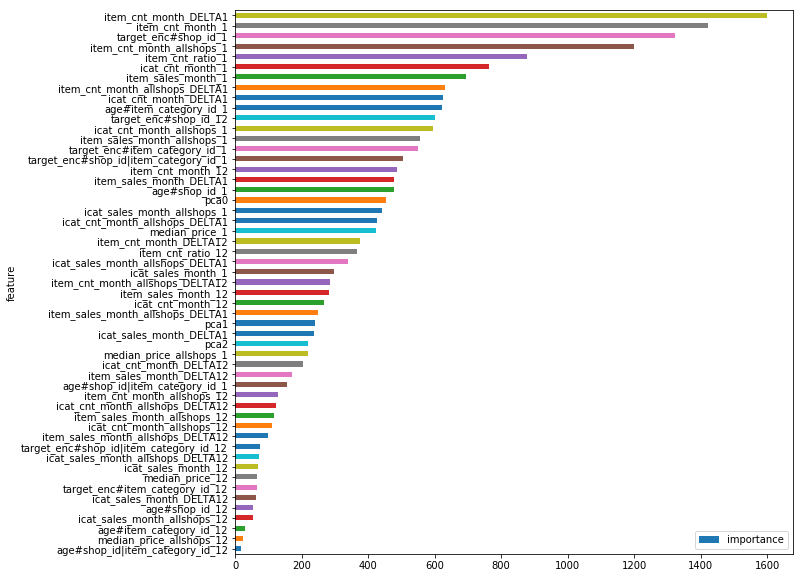

In [35]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': reg.feature_importances_})
feature_importances.sort_values(by='importance', ascending=True, inplace=True)
feature_importances.plot(x='feature', y='importance', kind='barh', sort_columns=True, figsize=(10,10))

In [36]:
def clip(s):
    return s.map(lambda x: max(0.0, min(20.0, x)))

def rmse(x, y):
    return math.sqrt(mean_squared_error(clip(x), clip(y)))

if is_validation():
    y_pred = pd.Series(reg.predict(X_val))
    print('validation RMSE score:', rmse(y_val, y_pred))

In [37]:
y_train_pred = pd.Series(reg.predict(X_train))
print('training RMSE score', rmse(y_train, y_train_pred))

training RMSE score 0.8833252026110717


# Hyperparameter tuning

In [ ]:
import hyperopt

min_rmse = 10
def objective(params):
    global min_rmse
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    
    model = LGBMRegressor(random_state=42, n_jobs=-1, **params)
    
    model.fit(X_train, y_train, early_stopping_rounds=200, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = pd.Series(model.predict(X_val))
    score = rmse(y_val, y_pred)
    if score < min_rmse:
        min_rmse = score
        print("RMSE {:.6f}: params={}".format(score, params))
    return -score

space = {
    'num_leaves': hyperopt.hp.quniform('num_leaves', 50, 200, 10),
    'max_depth': hyperopt.hp.quniform('max_depth', 3, 10, 1),
    'min_data_in_leaf': hyperopt.hp.quniform('min_data_in_leaf',  5, 25, 2),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.03, 0.9),
    'subsample': hyperopt.hp.uniform('subsample', 0.5, 1.0),
    'reg_lambda': hyperopt.hp.uniform('reg_lambda', 0.0, 50.0),
}

if is_tuning():
    best_params = hyperopt.fmin(
        fn=objective,
        space=space,
        algo=hyperopt.tpe.suggest,
        max_evals=1000)
    best_params

In [38]:
if is_test():
    y_test_pred = clip(pd.Series(reg.predict(X_test)))
    y_test_pred_df = pd.DataFrame(y_test_pred)
    y_test_pred_df.info()
    y_test_pred_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 1 columns):
0    214200 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [39]:
    df_submit = pd.DataFrame(df_test.loc[:,'ID'])
    df_submit['item_cnt_month'] = y_test_pred
    df_submit.to_csv('lgbm_tuned3.csv', index=False)
    df_submit.head()

,ID,item_cnt_month
0,0,0.476863
1,1,0.347894
2,2,1.041265
3,3,0.505291
4,4,0.347894
